## Лабораторная 3
Датасет: Набор данных для анализа и прогнозирования сердечного приступа

In [345]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import featuretools as ft
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

df = pd.read_csv(".//static//csv//heart_2020_cleaned.csv")

print(df.columns)
df.info()
df.head()

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race            

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  
3               No       Good        6.0     No            No        Yes  
4              Yes  Very good        8.0     No            No         No

### Бизнес цели и цели технического проекта
1. Улучшение профилактики сердечно-сосудистых заболеваний

   - Бизнес-цель: Повышение точности прогнозирования риска сердечно-сосудистых заболеваний среди пациентов для более раннего вмешательства и снижения частоты обострений. Определение основных факторов риска, чтобы медперсонал мог предоставлять более целенаправленные рекомендации по улучшению здоровья.

   - Цель технического проекта: Разработка классификационной модели для предсказания вероятности сердечно-сосудистых заболеваний на основе данных (возраст, индекс массы тела, физическая активность, курение и т. д.), что поможет выделить группы высокого риска. Интеграция этой модели в систему поддержки принятия решений для врачей, чтобы улучшить качество и своевременность рекомендаций.

2. Снижение расходов на лечение сердечно-сосудистых заболеваний

   - Бизнес-цель: Оптимизация затрат на лечение сердечно-сосудистых заболеваний путем эффективного распределения ресурсов и проведения профилактических мер среди целевых групп.

   - Цель технического проекта: Создание системы оценки индивидуального риска сердечно-сосудистых заболеваний для пациентов, которая позволит медицинским учреждениям и страховым компаниям выделять целевые группы для проведения превентивных мероприятий, тем самым сокращая затраты на лечение.

Проверка на пустые значения и дубликаты

In [346]:
null_values = df.isnull().sum()
print("Пустые значения по столбцам:")
print(null_values)

duplicates = df.duplicated().sum()
print(f"\nКоличество дубликатов: {duplicates}")

print("\nСтатистический обзор данных:")
df.describe()

Пустые значения по столбцам:
HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

Количество дубликатов: 18078

Статистический обзор данных:


BMI  PhysicalHealth   MentalHealth      SleepTime
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000

Пустых значений нет, но есть дубликаты, удаляем их

In [347]:
df = df.drop_duplicates()
duplicates = df.duplicated().sum()
print(f"\nКоличество дубликатов: {duplicates}")


Количество дубликатов: 0


Преобразуем строковые значение в столбце 'Сердечный приступ' в числовые значения. Это понадобится для расчёта качества набора признаков.

In [348]:
map_stroke_to_int = {'No': 0, 'Yes': 1}

df['Stroke'] = df['Stroke'].map(map_stroke_to_int).astype('int32')

Создание выборок

In [349]:
# Разделение данных на признаки (X) и целевую переменную (y)
# В данном случае мы хотим предсказать 'stroke'
X = df.drop(columns=['Stroke'])
y = df['Stroke']

# Разбиение данных на обучающую и тестовую выборки
# Сначала разделим на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Затем разделим обучающую выборку на обучающую и контрольную
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

# Проверка размеров выборок
print("Размер обучающей выборки:", X_train.shape)
print("Размер контрольной выборки:", X_val.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (147840, 17)
Размер контрольной выборки: (63361, 17)
Размер тестовой выборки: (90516, 17)


Оценим сбалансированность выборок

Распределение классов в обучающей выборке:
Stroke
0    0.960045
1    0.039955
Name: proportion, dtype: float64

Распределение классов в контрольной выборке:
Stroke
0    0.95977
1    0.04023
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Stroke
0    0.96014
1    0.03986
Name: proportion, dtype: float64


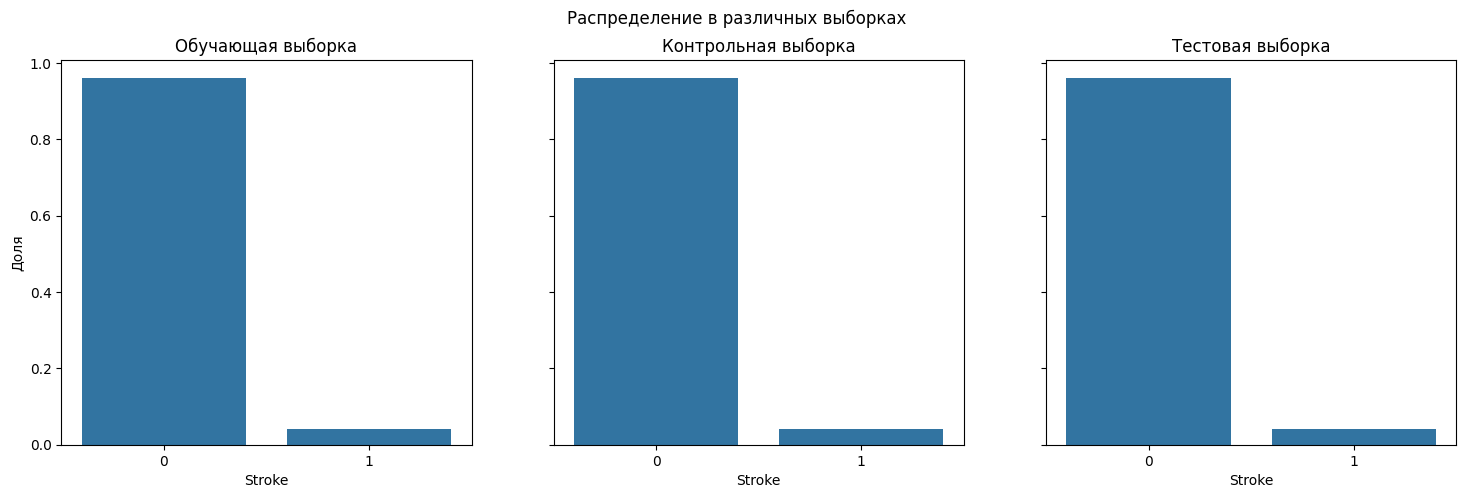

In [350]:
# Функция для анализа сбалансированности
def analyze_balance(y_train, y_val, y_test, y_name):
    # Распределение классов
    print("Распределение классов в обучающей выборке:")
    print(y_train.value_counts(normalize=True))
    
    print("\nРаспределение классов в контрольной выборке:")
    print(y_val.value_counts(normalize=True))
    
    print("\nРаспределение классов в тестовой выборке:")
    print(y_test.value_counts(normalize=True))

    # Создание фигуры и осей для трех столбчатых диаграмм
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle('Распределение в различных выборках')

    # Обучающая выборка
    sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts(normalize=True), ax=axes[0])
    axes[0].set_title('Обучающая выборка')
    axes[0].set_xlabel(y_name)
    axes[0].set_ylabel('Доля')

    # Контрольная выборка
    sns.barplot(x=y_val.value_counts().index, y=y_val.value_counts(normalize=True), ax=axes[1])
    axes[1].set_title('Контрольная выборка')
    axes[1].set_xlabel(y_name)

    # Тестовая выборка
    sns.barplot(x=y_test.value_counts().index, y=y_test.value_counts(normalize=True), ax=axes[2])
    axes[2].set_title('Тестовая выборка')
    axes[2].set_xlabel(y_name)

    plt.show()

analyze_balance(y_train, y_val, y_test, 'Stroke')

Выборки несбалансированны. Необходимо сбалансировать обучающую и контрольную выборки, чтобы получить лучшие результаты при обучении модели. Для балансировки применим RandomOverSampler:

Распределение классов в обучающей выборке:
Stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

Распределение классов в контрольной выборке:
Stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Stroke
0    0.96014
1    0.03986
Name: proportion, dtype: float64


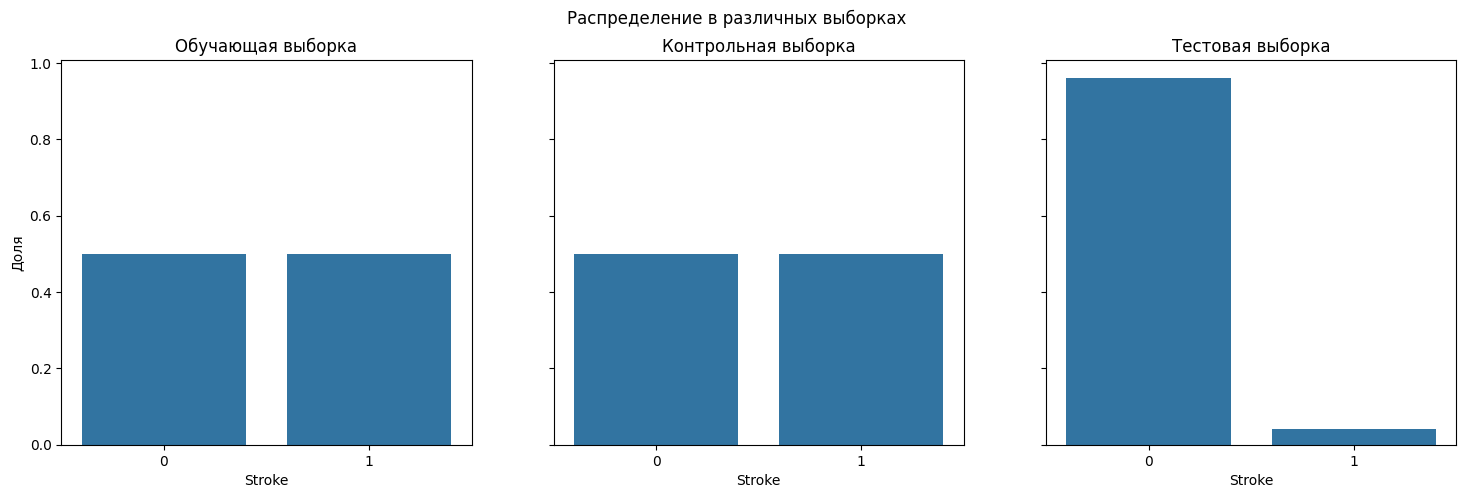

In [351]:
ros = RandomOverSampler(random_state=42)

# Применение RandomOverSampler для балансировки выборок
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = ros.fit_resample(X_val, y_val)

# Проверка сбалансированности после RandomOverSampler
analyze_balance(y_train_resampled, y_val_resampled, y_test, 'Stroke')

Перейдем к конструированию признаков.
Применим унитарное кодирование категориальных признаков (one-hot encoding), переведя их в бинарные вектора:

In [352]:
# Определение категориальных признаков
categorical_features = ['HeartDisease', 'Smoking', 'AlcoholDrinking',
       'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth',
       'Asthma', 'KidneyDisease', 'SkinCancer']

# Применение one-hot encoding к обучающей выборке
X_train_encoded = pd.get_dummies(X_train_resampled, columns=categorical_features, drop_first=True)

# Применение one-hot encoding к контрольной выборке
X_val_encoded = pd.get_dummies(X_val_resampled, columns=categorical_features, drop_first=True)

# Применение one-hot encoding к тестовой выборке
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

print(X_train_encoded.head())

     BMI  PhysicalHealth  MentalHealth  SleepTime  HeartDisease_Yes  \
0  26.50             5.0           0.0        7.0             False   
1  33.91             0.0           0.0        7.0             False   
2  42.57             4.0           5.0        6.0             False   
3  32.08             0.0           0.0        6.0             False   
4  15.78             1.0           3.0        6.0             False   

   Smoking_Yes  AlcoholDrinking_Yes  DiffWalking_Yes  Sex_Male  \
0        False                False            False      True   
1        False                False            False      True   
2        False                False            False      True   
3        False                False            False      True   
4        False                False            False      True   

   AgeCategory_25-29  ...  Diabetic_Yes  Diabetic_Yes (during pregnancy)  \
0              False  ...         False                            False   
1              False  ..

Далее применим дискретизацию к числовым признакам 

In [353]:
bmi_bins = [0, 18.5, 25, 30, 40, 60]
bmi_labels = ["Underweight", "Normal", "Overweight", "Obese", "Severely Obese"]


X_train_encoded['BMI_binned'] = pd.cut(X_train_encoded['BMI'], bins=bmi_bins, labels=bmi_labels)
X_val_encoded['BMI_binned'] = pd.cut(X_val_encoded['BMI'], bins=bmi_bins, labels=bmi_labels)

X_test_encoded['BMI_binned'] = pd.cut(X_test_encoded['BMI'], bins=bmi_bins, labels=bmi_labels)

print(X_train_encoded.head())

     BMI  PhysicalHealth  MentalHealth  SleepTime  HeartDisease_Yes  \
0  26.50             5.0           0.0        7.0             False   
1  33.91             0.0           0.0        7.0             False   
2  42.57             4.0           5.0        6.0             False   
3  32.08             0.0           0.0        6.0             False   
4  15.78             1.0           3.0        6.0             False   

   Smoking_Yes  AlcoholDrinking_Yes  DiffWalking_Yes  Sex_Male  \
0        False                False            False      True   
1        False                False            False      True   
2        False                False            False      True   
3        False                False            False      True   
4        False                False            False      True   

   AgeCategory_25-29  ...  Diabetic_Yes (during pregnancy)  \
0              False  ...                            False   
1              False  ...                           

Применим ручной синтез признаков. К примеру, можно создать фактор риска для сердечных заболеваний: комбинированный признак на основе факторов риска, таких как курение, диабет, употребление алкоголя и наличие болезней.

In [354]:
X_train_encoded['RiskFactor'] = ((X_train_encoded['Smoking_Yes'] == True) | 
                      (X_train_encoded['Diabetic_Yes'] == True) | 
                      (X_train_encoded['AlcoholDrinking_Yes'] == True) | 
                      (X_train_encoded['KidneyDisease_Yes'] == True) | 
                      (X_train_encoded['SkinCancer_Yes'] == True)).astype(int)

print(X_train_encoded.head())

     BMI  PhysicalHealth  MentalHealth  SleepTime  HeartDisease_Yes  \
0  26.50             5.0           0.0        7.0             False   
1  33.91             0.0           0.0        7.0             False   
2  42.57             4.0           5.0        6.0             False   
3  32.08             0.0           0.0        6.0             False   
4  15.78             1.0           3.0        6.0             False   

   Smoking_Yes  AlcoholDrinking_Yes  DiffWalking_Yes  Sex_Male  \
0        False                False            False      True   
1        False                False            False      True   
2        False                False            False      True   
3        False                False            False      True   
4        False                False            False      True   

   AgeCategory_25-29  ...  PhysicalActivity_Yes  GenHealth_Fair  \
0              False  ...                  True           False   
1              False  ...                 

Используем масштабирование признаков

In [355]:
numerical_features = ['PhysicalHealth', 'MentalHealth', 'SleepTime']

scaler = StandardScaler()
X_train_encoded[numerical_features] = scaler.fit_transform(X_train_encoded[numerical_features])
X_val_encoded[numerical_features] = scaler.transform(X_val_encoded[numerical_features])
X_test_encoded[numerical_features] = scaler.transform(X_test_encoded[numerical_features])

print(X_train_encoded.head())

     BMI  PhysicalHealth  MentalHealth  SleepTime  HeartDisease_Yes  \
0  26.50       -0.099915     -0.540452  -0.070949             False   
1  33.91       -0.581538     -0.540452  -0.070949             False   
2  42.57       -0.196239      0.006442  -0.646839             False   
3  32.08       -0.581538     -0.540452  -0.646839             False   
4  15.78       -0.485213     -0.212315  -0.646839             False   

   Smoking_Yes  AlcoholDrinking_Yes  DiffWalking_Yes  Sex_Male  \
0        False                False            False      True   
1        False                False            False      True   
2        False                False            False      True   
3        False                False            False      True   
4        False                False            False      True   

   AgeCategory_25-29  ...  PhysicalActivity_Yes  GenHealth_Fair  \
0              False  ...                  True           False   
1              False  ...                 

И также попробуем сконструировать признаки, используя фреймворк Featuretools:

In [356]:
data = X_train_encoded.copy()

es = ft.EntitySet(id="patients")

es = es.add_dataframe(dataframe_name="strokes_data", dataframe=data, index="index", make_index=True)

feature_matrix, feature_defs = ft.dfs(
    entityset=es, 
    target_dataframe_name="strokes_data",
    max_depth=1
)

print(feature_matrix.head())

c:\Users\User\Desktop\aim\aimvenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


         BMI  PhysicalHealth  MentalHealth  SleepTime  HeartDisease_Yes  \
index                                                                     
0      26.50       -0.099915     -0.540452  -0.070949             False   
1      33.91       -0.581538     -0.540452  -0.070949             False   
2      42.57       -0.196239      0.006442  -0.646839             False   
3      32.08       -0.581538     -0.540452  -0.646839             False   
4      15.78       -0.485213     -0.212315  -0.646839             False   

       Smoking_Yes  AlcoholDrinking_Yes  DiffWalking_Yes  Sex_Male  \
index                                                                
0            False                False            False      True   
1            False                False            False      True   
2            False                False            False      True   
3            False                False            False      True   
4            False                False            Fal

#### Оценка качества набора признаков
Представим основные оценки качества наборов признаков:

- Предсказательная способность (для задачи классификации) Метрики: Accuracy, Precision, Recall, F1-Score, ROC AUC

    Методы: Обучение модели на обучающей выборке и оценка на контрольной и тестовой выборках.

- Скорость вычисления

    Методы: Измерение времени выполнения генерации признаков и обучения модели.

- Надежность

    Методы: Кросс-валидация, анализ чувствительности модели к изменениям в данных.

- Корреляция

    Методы: Анализ корреляционной матрицы признаков, удаление мультиколлинеарных признаков.

- Цельность

    Методы: Проверка логической связи между признаками и целевой переменной, интерпретация результатов модели.

In [357]:
X_train_encoded = pd.get_dummies(X_train_encoded, drop_first=True)
X_val_encoded = pd.get_dummies(X_val_encoded, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_encoded, drop_first=True)

all_columns = X_train_encoded.columns
X_train_encoded = X_train_encoded.reindex(columns=all_columns, fill_value=0)
X_val_encoded = X_val_encoded.reindex(columns=all_columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=all_columns, fill_value=0)

# Выбор модели
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Начинаем отсчет времени
start_time = time.time()
model.fit(X_train_encoded, y_train_resampled)

# Время обучения модели
train_time = time.time() - start_time

print(f'Время обучения модели: {train_time:.2f} секунд')


Время обучения модели: 36.52 секунд


In [358]:
# Получение важности признаков
importances = model.feature_importances_
feature_names = X_train_encoded.columns

# Сортировка признаков по важности
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
                             feature  importance
0                                BMI    0.194905
3                          SleepTime    0.086714
1                     PhysicalHealth    0.074056
4                   HeartDisease_Yes    0.065638
7                    DiffWalking_Yes    0.057683
2                       MentalHealth    0.057339
8                           Sex_Male    0.028562
20           AgeCategory_80 or older    0.025721
29              PhysicalActivity_Yes    0.023747
27                      Diabetic_Yes    0.023346
30                    GenHealth_Fair    0.022295
34                        Asthma_Yes    0.019722
19                 AgeCategory_75-79    0.017912
5                        Smoking_Yes    0.017702
37                        RiskFactor    0.017532
31                    GenHealth_Good    0.016946
18                 AgeCategory_70-74    0.015593
33               GenHealth_Very good    0.015544
25                        Race_White    0.014721


Accuracy: 0.9562618763533519
Precision: 0.10204081632653061
Recall: 0.012472283813747228
F1 Score: 0.02222771054581378
ROC AUC: 0.5039578706315019
Cross-validated Accuracy: 0.9940253495420259


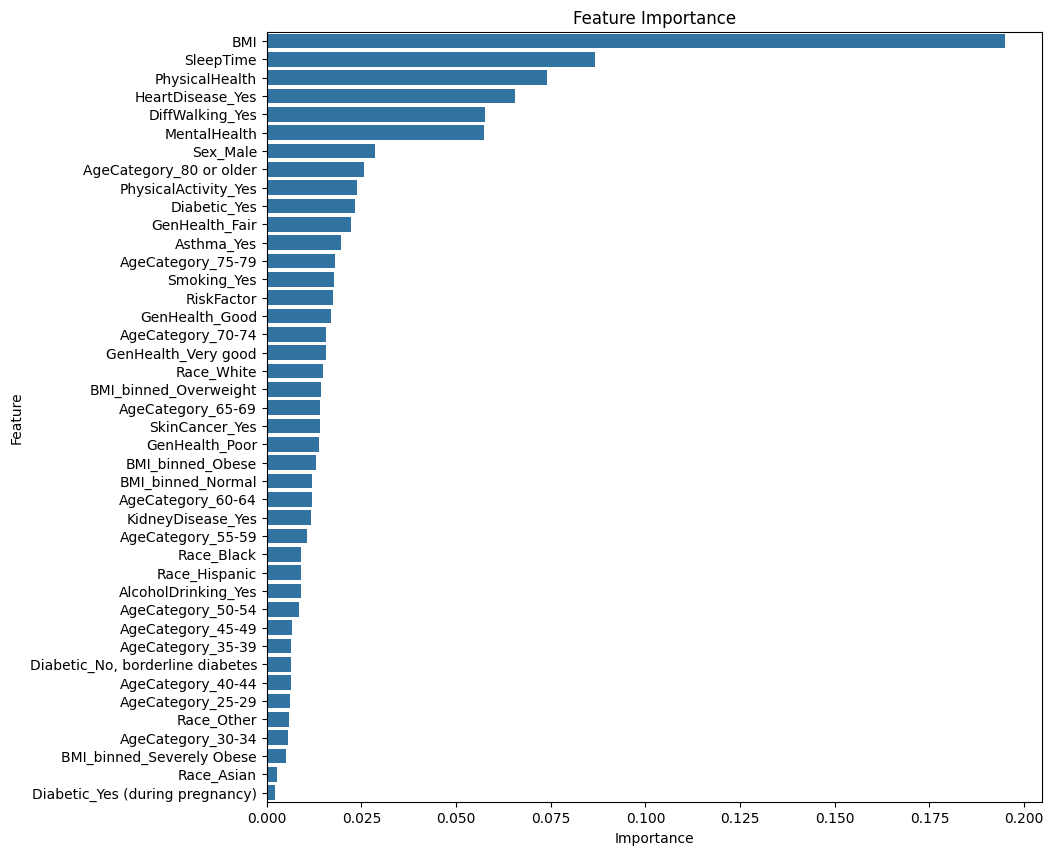

Train Accuracy: 0.9997146540973558
Train Precision: 0.9994296336980861
Train Recall: 1.0
Train F1 Score: 0.9997147354964131
Train ROC AUC: 0.9997146540973557


In [359]:
# Предсказание и оценка
y_pred = model.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Кросс-валидация
scores = cross_val_score(model, X_train_encoded, y_train_resampled, cv=5, scoring='accuracy')
accuracy_cv = scores.mean()
print(f"Cross-validated Accuracy: {accuracy_cv}")

# Анализ важности признаков
feature_importances = model.feature_importances_
feature_names = X_train_encoded.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# Проверка на переобучение
y_train_pred = model.predict(X_train_encoded)

accuracy_train = accuracy_score(y_train_resampled, y_train_pred)
precision_train = precision_score(y_train_resampled, y_train_pred)
recall_train = recall_score(y_train_resampled, y_train_pred)
f1_train = f1_score(y_train_resampled, y_train_pred)
roc_auc_train = roc_auc_score(y_train_resampled, y_train_pred)

print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")
print(f"Train ROC AUC: {roc_auc_train}")